# Modeling Diffusion from Inner Stream to Outer Stream as a Function of Inner Stream Flow Rate

Having observed a dramatic increase in the number of bubbles in the inner stream with increasing flow rate, I want to check to what extent the increase in the inner stream width and flow speed increases the amount of CO2 that remains in the inner stream near the end of the observation capillary (since the measurements in question were made at 96 mm downstream.)

The experiment was performed on September 5, 2020.

In [18]:
# adds custom libraries to path
import sys
sys.path.append('../libs/')

# imports standard libraries
import numpy as np
import matplotlib.pyplot as plt

# imports custom libraries
import polyco2
import diffn
import flow
import plot.diffn as pltd

from importlib import reload


# flow parameters
# viscosity of inner and outer streams [Pa.s]
eta_i = 0.25 # rough estimate of VORANOL 360 + CO2 dissolved so should be lower
eta_o = 4.815
# length of observation capillary [m]
L = 10E-2
# outer stream radius [m]
R_o = 150E-6
Q_o = 200 # outer stream flow rate, input to ISCO 260 D [uL/min]
# list of inner stream flow rates [uL/min]
Q_i_list = [50, 100, 200, 400, 800]
# saturation pressure [Pa]
p_s = 80E5
# distance down capillary at which measurements were taken [m]
d = 0.096

# grid parameters
r_min = 0 # [m]
r_max = 150E-6 # outer radius [m]
N = 50 # number of grid spacings 
# computes mesh [m]
r_arr = np.linspace(r_min, r_max, N+1)

# diffusion model parameters 
dt = 10E-6 # time step [s]
dcdt_fn = diffn.calc_dcdt_cyl
bc_specs_list = [(diffn.neumann, 0, 1, 0, r_arr), (diffn.dirichlet, -1, 0)]
dc_c_s_frac = 0.01 # step size in concentration for estimating dD/dc as a fraction of saturation concentration

# load data (interfacial tension, solubility, and diffusivity) for polyols? we don't have data for VORANOL 360...use 1k3f
polyol_data_file = '1k3f_22c.csv'

# plot parameters
t_fs = 18
ax_fs = 16
tk_fs = 14
l_fs = 12

# CONVERSIONS
m_2_um = 1E6
m_2_mm = 1E3
s_2_ms = 1E3
uLmin_2_m3s = 1/60E9

### Set Initial Concentration Profile

We assume saturation in the inner stream up to the inner radius and no CO2 in the outer stream.

### Compute Diffusion of CO2 from Inner to Outer Stream

In [19]:
R_i_list = []
v_list = []
t_list = []
c_list = []

for Q_i in Q_i_list:
    _, R_i, v = flow.get_dp_R_i_v_max(eta_i, eta_o, L, Q_i*uLmin_2_m3s, Q_o*uLmin_2_m3s, R_o, SI=True)
    R_i_list += [R_i]
    v_list += [v]
    
    # creates initial concentration profile [kg CO2 / m^3 polyol-CO2]
    c_0 = np.zeros([N+1])
    c_s = polyco2.calc_c_s(p_s, polyol_data_file)
    c_0[r_arr <= R_i] = c_s
    dc = c_s*dc_c_s_frac
    t_f = d/v
    t, c = diffn.go(dt, t_f, r_arr, list(c_0), dcdt_fn, bc_specs_list, dc, polyol_data_file)
    
    # list of times and concentrations
    t_list += [t[-1]]
    c_list += [c[-1]]
    
    print('Finished Q_i = {0:d} uL/min'.format(Q_i))

Finished Q_i = 50 uL/min
Finished Q_i = 100 uL/min
Finished Q_i = 200 uL/min
Finished Q_i = 400 uL/min
Finished Q_i = 800 uL/min


### Plot Results

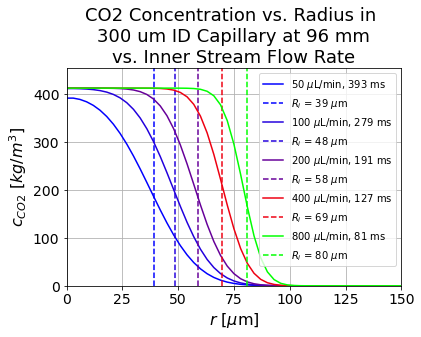

In [21]:
reload(pltd)
ax = pltd.compare_sheath_Qi(d, r_arr, c_list, Q_i_list, R_i_list, R_o, v_list, c_s, l_fs=10)
plt.grid()

In [17]:
v_list

[0.3435867399140641,
 0.5016874581533411,
 0.7556453181892849,
 1.1720664294991916]